# Calibration of SGLD hyperparameters for MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/sgld_calibration.ipynb)

This notebook walks through the process for calibrating hyperparameters for Stochastic Gradient Langevin Dynamics (SGLD) based LLC (or $\hat\lambda$) estimation. The model we'll use is a small 2-layer ReLU network (~1M params) trained on the MNIST dataset.

Note that in this case, the theoretical value of the LLC is not known. The intent of this notebook is to demonstrate that, even when we don't have access to the ground truth $\lambda$, there are diagnostic processes that can allow us to be more confident that $\hat\lambda$ preserves desirable properties of $\lambda$, such as maintaining relative ordering of degeneracy. This also reflects most real-world situations where we're interested in $\hat\lambda$ estimations.

Finally, we should emphasize that this is more an art than a science. There is still a great deal of uncertainty and many unknown unknowns. The process of LLC estimation is a **work in progress**, and this notebook only reflects the best state of our knowledge at the time of the creation of this notebook.

This notebook is split into 5 sections:
1. Data preparation
2. Training model checkpoints
3. Running calibration sweep
4. Plotting LLC estimations over time
5. Selecting $\epsilon$ and $\gamma$

In [1]:
%pip install devinterp torchvision
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.llc import estimate_learning_coeff_with_summary, sample
from devinterp.slt.mala import MalaAcceptanceRate

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

In [3]:
# Define the neural network
class MNIST(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(MNIST, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Train/test utils
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

### 1. Data preparation

In [4]:
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = MNIST().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 15

60000


### 2. Training model checkpoints

In [5]:
# train model
train_losses = []
test_losses = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

  0%|          | 0/118 [00:00<?, ?it/s]

100%|██████████| 118/118 [00:09<00:00, 12.27it/s]


Epoch 1, Train Loss: 0.706206328409203, Test Loss: 0.2834306791424751


100%|██████████| 118/118 [00:08<00:00, 14.13it/s]


Epoch 2, Train Loss: 0.23401444203267663, Test Loss: 0.21462423652410506


100%|██████████| 118/118 [00:08<00:00, 14.64it/s]


Epoch 3, Train Loss: 0.16378073627918455, Test Loss: 0.14353236369788647


100%|██████████| 118/118 [00:07<00:00, 14.79it/s]


Epoch 4, Train Loss: 0.12149796136102434, Test Loss: 0.11576552577316761


100%|██████████| 118/118 [00:07<00:00, 15.12it/s]


Epoch 5, Train Loss: 0.09557783063816822, Test Loss: 0.11372877340763807


100%|██████████| 118/118 [00:07<00:00, 15.06it/s]


Epoch 6, Train Loss: 0.07811766746059312, Test Loss: 0.09399579903110862


100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch 7, Train Loss: 0.06412400002196683, Test Loss: 0.08599145393818616


100%|██████████| 118/118 [00:08<00:00, 14.13it/s]


Epoch 8, Train Loss: 0.05378290202658055, Test Loss: 0.08214869257062674


100%|██████████| 118/118 [00:07<00:00, 14.76it/s]


Epoch 9, Train Loss: 0.044670379120793385, Test Loss: 0.06925603989511728


100%|██████████| 118/118 [00:07<00:00, 15.13it/s]


Epoch 10, Train Loss: 0.03783598630610159, Test Loss: 0.06568215531297028


100%|██████████| 118/118 [00:07<00:00, 15.11it/s]


Epoch 11, Train Loss: 0.03248294161127533, Test Loss: 0.06470282594673335


100%|██████████| 118/118 [00:07<00:00, 15.12it/s]


Epoch 12, Train Loss: 0.02674152286944248, Test Loss: 0.06284198383800685


100%|██████████| 118/118 [00:07<00:00, 15.08it/s]


Epoch 13, Train Loss: 0.02296819974336836, Test Loss: 0.06516343289986253


100%|██████████| 118/118 [00:08<00:00, 14.50it/s]


Epoch 14, Train Loss: 0.019258979522481054, Test Loss: 0.06331468466669321


100%|██████████| 118/118 [00:07<00:00, 14.98it/s]


Epoch 15, Train Loss: 0.016390777236418956, Test Loss: 0.06331480867229403


Plotting the train and test loss shows that training has not entirely converged, but still we should be able to get reasonable LLC estimates if we tune our hyperparameters correctly.

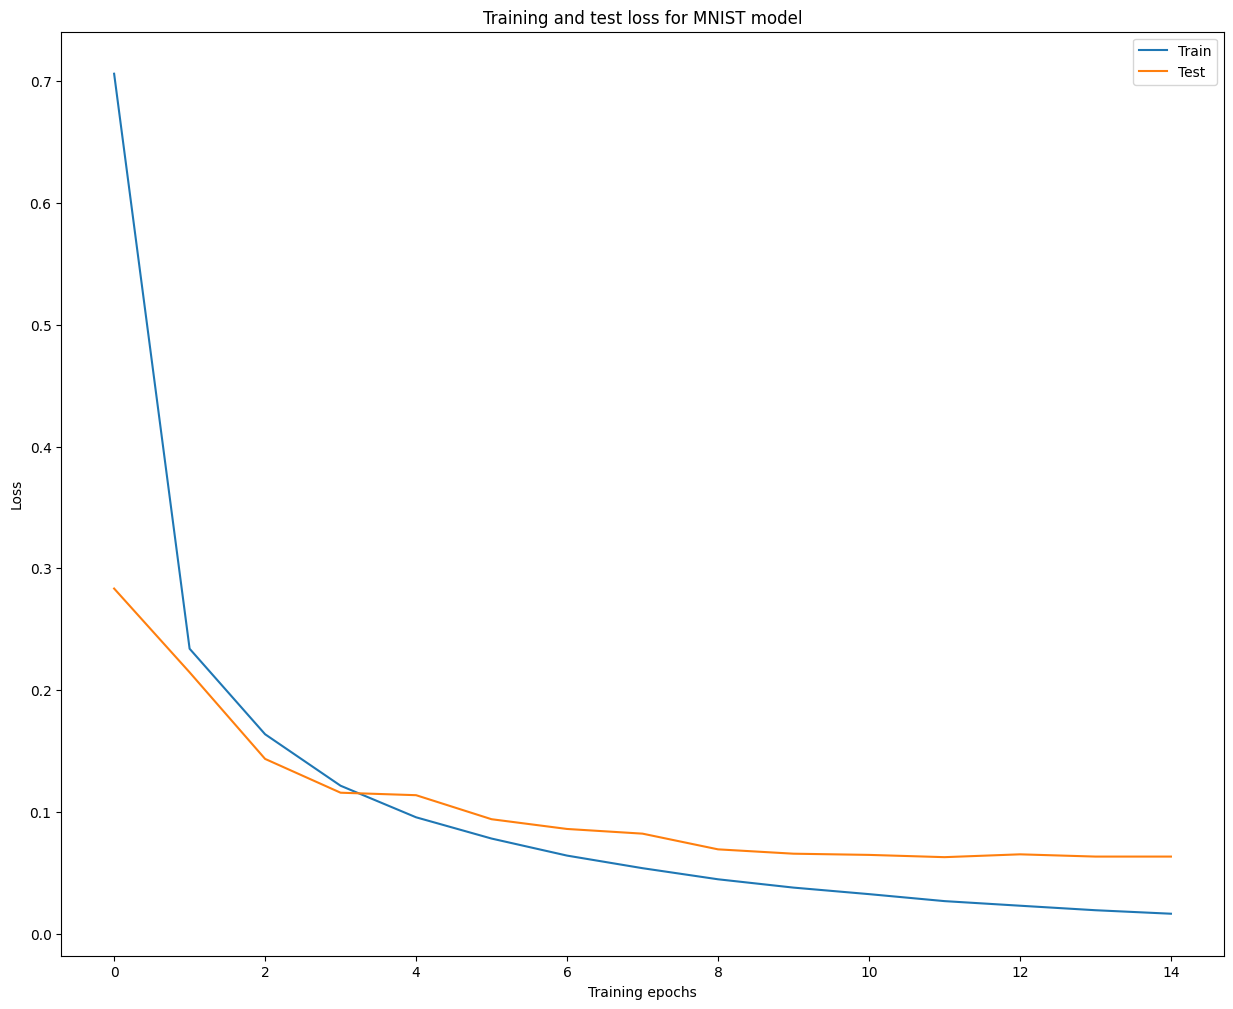

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Training and test loss for MNIST model')
plt.legend()
plt.show()

### 3. Running calibration sweep

The main idea is to sweep across a few orders of magnitude of $\epsilon$ and $\gamma$. We look at the [MALA acceptance probabilities](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm) of SGLD chains, aiming for a value that's high but $< 1$. (Note: we are not using MALA to sample, only to observe the health of our chain!) A reasonable starting point is to sweep $\epsilon$ across 5 orders of magnitude, and $\gamma$ across 3.

In [7]:
def plot_single_graph(result, title=""):
    llc_color = "teal"
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result["loss/trace"]
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result["llc/means"]
    stds = result["llc/stds"]
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx()
    axs2.plot(
        sgld_steps,
        means,
        color=llc_color,
        linestyle="--",
        linewidth=2,
        label=f"llc",
        zorder=3,
    )
    axs2.fill_between(
        sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
    )

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel("SGLD time step")
    axs.set_ylabel("loss")
    axs2.set_ylabel("llc", color=llc_color)
    axs2.tick_params(axis="y", labelcolor=llc_color)
    axs.axhline(color="black", linestyle=":")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sweep_single_model(results, to_test, name, **kwargs):
    llc_color = "teal"
    fig, axs = plt.subplots(len(to_test))

    for i, test_value in enumerate(to_test):
        result = results[(test_value)]
        # plot loss traces
        loss_traces = result["loss/trace"]
        for trace in loss_traces:
            init_loss = trace[0]
            zeroed_trace = trace - init_loss
            sgld_steps = list(range(len(trace)))
            axs[i].plot(sgld_steps, zeroed_trace)

        # plot llcs
        means = result["llc/means"]
        stds = result["llc/stds"]
        sgld_steps = list(range(len(means)))
        axs2 = axs[i].twinx()
        axs2.plot(
            sgld_steps,
            means,
            color=llc_color,
            linestyle="--",
            linewidth=2,
            label=f"llc",
            zorder=3,
        )
        axs2.fill_between(
            sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
        )

        # center zero, assume zero is in the range of both y axes already
        y1_min, y1_max = axs[i].get_ylim()
        y2_min, y2_max = axs2.get_ylim()
        y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
        y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
        percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
        y1_amt_to_add = (y1_max - y1_min) * percent_to_add
        y2_amt_to_add = (y2_max - y2_min) * percent_to_add
        if y1_zero_ratio < y2_zero_ratio:
            # add to bottom of y1 and top of y2
            y1_min -= y1_amt_to_add
            y2_max += y2_amt_to_add
        elif y2_zero_ratio < y1_zero_ratio:
            # add to bottom of y2 and top of y1
            y2_min -= y2_amt_to_add
            y1_max += y1_amt_to_add
        axs[i].set_ylim(y1_min, y1_max)
        axs2.set_ylim(y2_min, y2_max)

        axs[i].set_title(f"${name}$ = {test_value}")
        # only show x axis label on last row
        if i == len(to_test) - 1:
            axs[i].set_xlabel("SGLD time step")
        axs[i].set_ylabel("loss")
        axs2.set_ylabel("llc", color=llc_color)
        axs2.tick_params(axis="y", labelcolor=llc_color)
    if kwargs.get("title"):
        fig.suptitle(kwargs["title"], fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
EPSILONS = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
GAMMAS = [100.0, 1.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}


def estimate_mala_sweeper(model):
    for epsilon in EPSILONS:
        for gamma in GAMMAS:
            mala_estimator = MalaAcceptanceRate(
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                num_samples=len(train_data),
                learning_rate=epsilon,
                device=DEVICE,
            )

            result = estimate_learning_coeff_with_summary(
                model,
                train_loader,
                criterion=criterion,
                optimizer_kwargs=dict(
                    lr=epsilon, elasticity=gamma, num_samples=len(train_data)
                ),
                sampling_method=SGLD,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                callbacks=[mala_estimator],
                verbose=False,
                online=True,
            )
            mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
            results[(epsilon, gamma)] = result
            print(
                f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
            )


estimate_mala_sweeper(model)

/home/paperspace/devinterp/src/devinterp/slt/sampler.py:46: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn('You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)')


/home/paperspace/devinterp/src/devinterp/slt/llc.py:111: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.llc_stds = self.llcs.std(dim=0)


epsilon 0.001, gamma 100.0, mala rate: nan
epsilon 0.001, gamma 1.0, mala rate: nan
epsilon 0.0001, gamma 100.0, mala rate: 0.18090009689331055
epsilon 0.0001, gamma 1.0, mala rate: 0.4429827928543091
epsilon 1e-05, gamma 100.0, mala rate: 9.84054071555214e-19
epsilon 1e-05, gamma 1.0, mala rate: 0.4782722592353821
epsilon 1e-06, gamma 100.0, mala rate: 0.07097503542900085
epsilon 1e-06, gamma 1.0, mala rate: 0.5364353060722351
epsilon 1e-07, gamma 100.0, mala rate: 0.4020337164402008
epsilon 1e-07, gamma 1.0, mala rate: 0.5196059942245483


Judging by this, $\epsilon = 1e^{-3}$ is out (did not converge), and a $\gamma$ of $100$ is too high. A higher MALA acceptance prob would be better (ideally we'd aim for $.9$) but that might not be possible for this model. The higher learning rate is generally preferred, but we have to be careful not to get a thermalization peak at the start of sampling. Let's take a look at the loss curves next to check if our sampling works as expected.

### 4. Plotting LLC estimations over time

In these graphs, the LLC estimation mean is shown as a teal dotted line, and the standard deviation is shown as a shaded teal area around the mean. The remaining lines are the loss trace for each estimation. These are plotted with a shared $y=0$ line and have different scales of y axis (which can be seen on the left and right sides of each subplot).


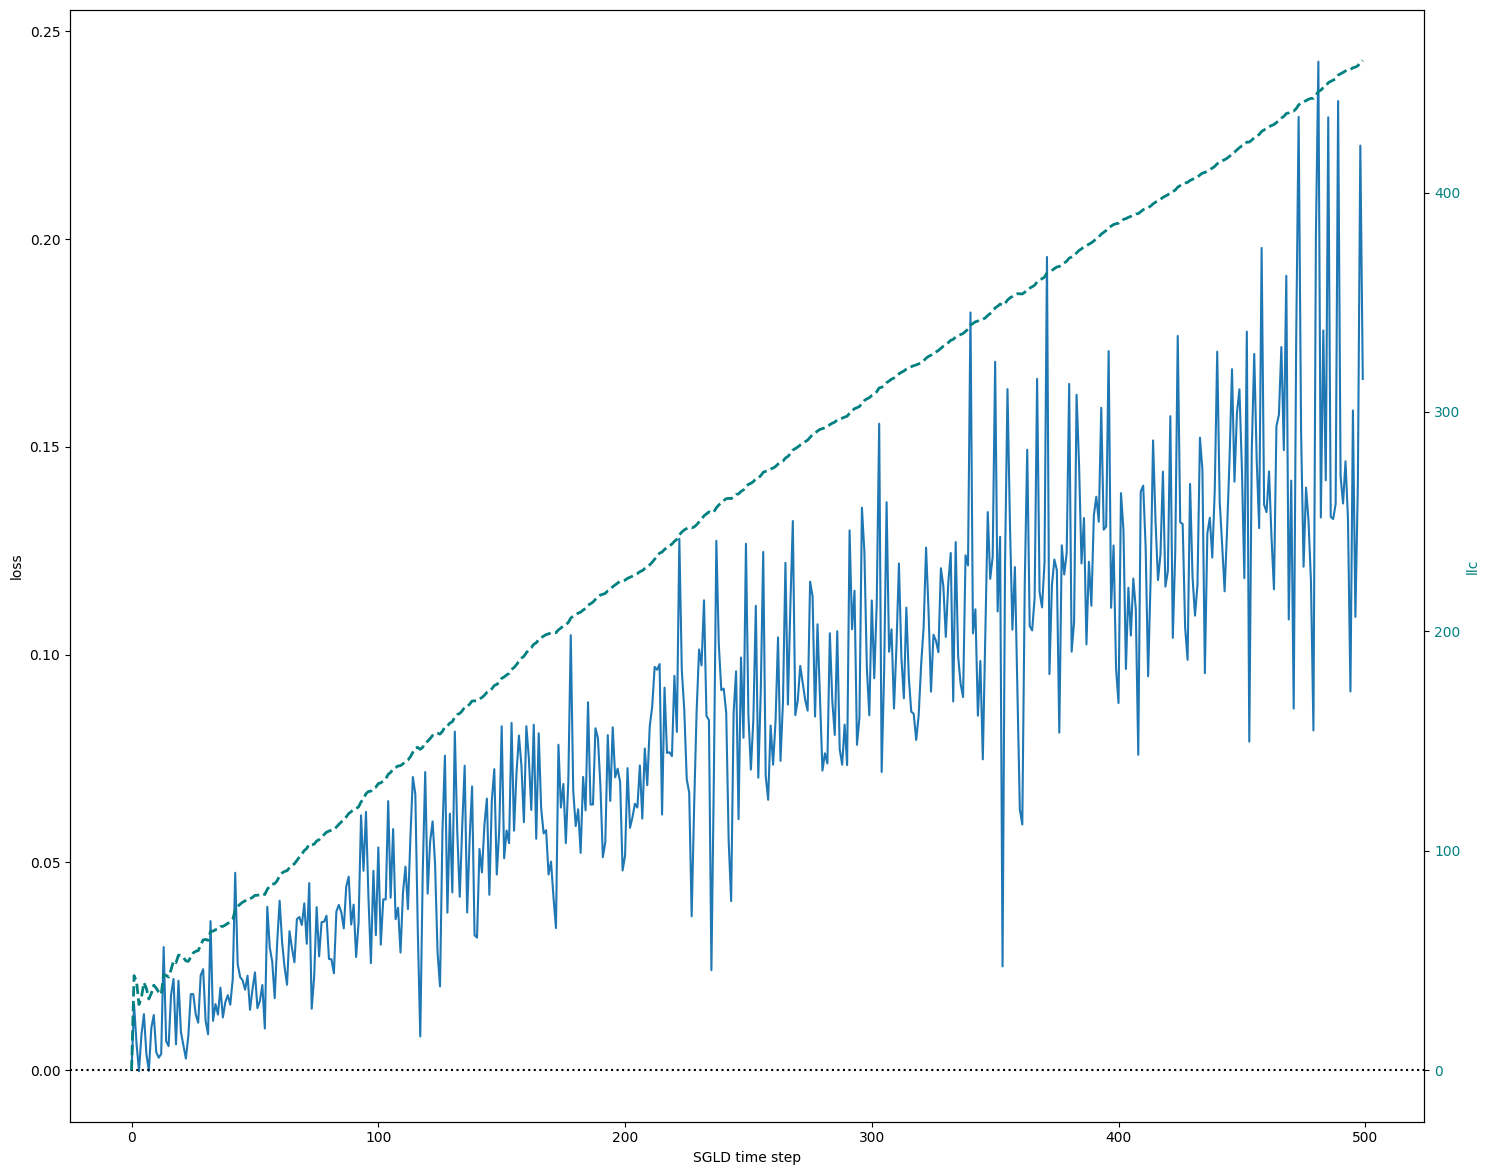

In [9]:
epsilon = 1e-5
gamma = 1
result = results[(epsilon, gamma)]
plot_single_graph(result)

This trace clearly has not converged yet, but looks healthy thus far (no big spikes, no flatlining).

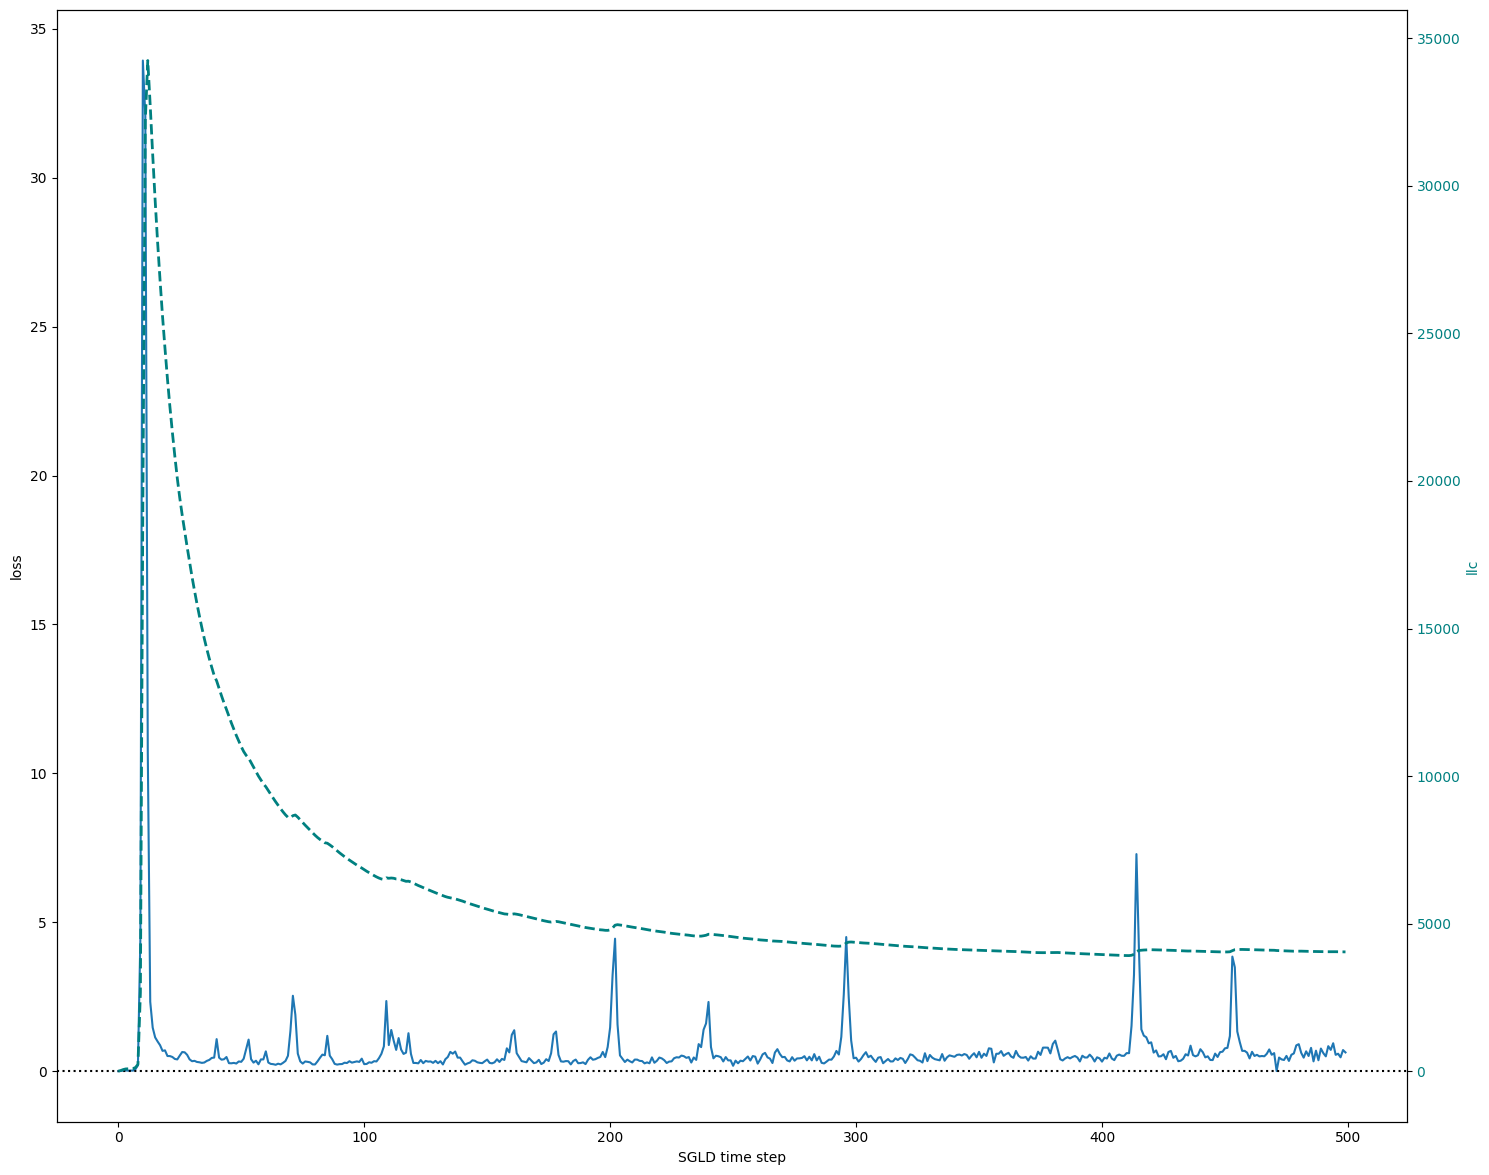

In [10]:
epsilon = 1e-4
gamma = 1
result = results[(epsilon, gamma)]
plot_single_graph(result)

In this case, there's a huge spike at the very start of the loss trace. In some models, this shape of LLC curve might happen because the SGLD sampling process is actually continuing to train the model, however in that case, we'd expect the loss traces to drop below the initial loss. In this example, the losses still remain positive after the initial spike, so it doesn't appear that SGLD is turning into continued training. It is currently unclear whether a spike (or in general, a not-monotonically-increasing curve) is a reason to invalidate a set of parameters, but it may be safest to consider it a yellow flag and pick a better set of parameters if possible.

**In general, the loss traces are a useful diagnostic tool and should be the second thing to check (after MALA prob) when there's odd behavior in your LLC estimation.**

Let's try running more samples on the $\epsilon=1e^{-5},\ \gamma=1$ case to see if it flattens out.

In [12]:
optim_kwargs = dict(
    lr=1e-5,
    elasticity=1.,
    num_samples=len(train_data),
)
result = estimate_learning_coeff_with_summary(
    model=checkpoints[-1],
    loader=train_loader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=optim_kwargs,
    num_chains=6,
    num_draws=5000,
    device=DEVICE,
    online=True,
)

Chain 0:   0%|          | 0/5000 [00:00<?, ?it/s]

Chain 5: 100%|██████████| 5000/5000 [00:39<00:00, 126.93it/s]


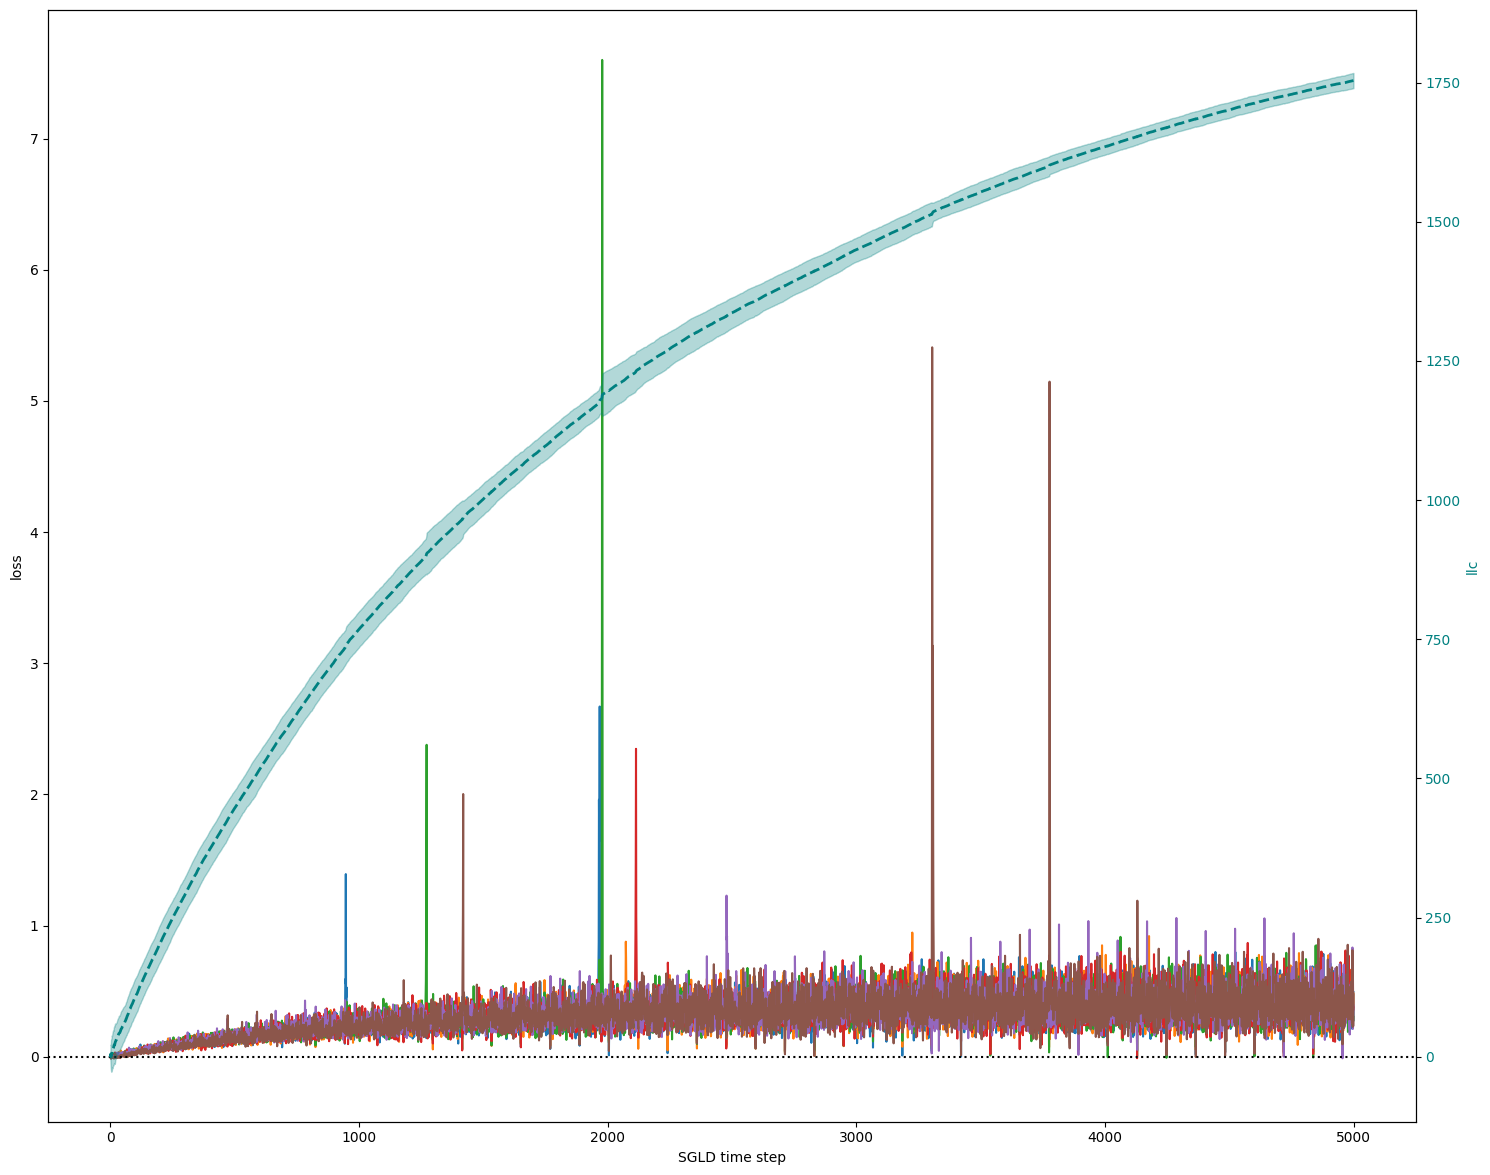

In [13]:
plot_single_graph(result)

### 5. Heuristics for selecting $\epsilon$ and $\gamma$

There is currently no One True Set of hyperparameters. Instead, the goal of calibration is to identify hyperparameters that maintain certain desirable properties. Some general such heuristics:
- Optimal traces should converge.
- Absolute $\hat\lambda$ estimates are not as important as relative $\hat\lambda$ estimates.
- The most important feature is that the relative ordering of estimates is maintained if you have different models to compare (e.g. different checkpoints).
- The MALA acceptance criterion should be as close as possible to $.9$ (but don't worry if you can't reach that). MALA acceptance probs of $0$ and $1$ are indications of unhealthy chains.
- The graph should not have negative dips (or not dip negative for very long).
- You can also examine the loss traces or other diagnostics to check that they look healthy (f.e. No Starting Peak), such as in the examples above.
  - A good set of loss traces should stay above the initial loss value (or at least not drop below it too far or for too many steps) and should not diverge away from the initial loss value.

If you don't get good results on the first sweep, you might recenter your sweep and try again.

### 6. Selecting $\epsilon$ and $\gamma$ in this MNIST example

- $\epsilon=1e^{-3}$ is definitely a no-go, since the values quickly diverge to NaN.
- $\epsilon=1e^{-4}$ causes a big spike in the initial LLC estimation. This should be avoided.
- With enough draws, the LLC estimation for $\epsilon=1e^{-5}, \ \gamma=1$ looks like it will converge nicely. The loss traces are basically flattened out as well, which is another indication that the LLC estimation should continue to converge without issue. In this first sweep, this would be my recommendation for hyperparameters.
- If more refinement is needed (e.g. it's necessary for LLC estimation to converge in a fewer number of draws), then another option would be to sweep with more granular values (say, a half order of magnitude) around $\epsilon=1e^{-5}, \ \gamma=1$